In [21]:
# Importa as bibliotecas necessárias para análise de dados e visualização
import pandas as pd                # Manipulação de dados em DataFrames
import matplotlib.pyplot as plt    # Criação de gráficos
import seaborn as sns              # Visualização de dados estatísticos
import numpy as np                 # Operações numéricas e manipulação de arrays

from sklearn.decomposition import PCA  # Análise de Componentes Principais
from sklearn.preprocessing import StandardScaler  # Normalização de dados
from sklearn.cluster import KMeans  # Algoritmo de agrupamento K-Means
from sklearn.metrics import silhouette_score # Métrica de avaliação de agrupamentos

# Importa função para buscar datasets do repositório UCI Machine Learning
from ucimlrepo import fetch_ucirepo

#### Código Notebook

In [22]:
# Função para plotar o scree plot e determinar o número ideal de componentes principais
def screeplot(princomp, ncomp=0, varexplicada=0, criterio=1):

    # Define o critério para o número de componentes principais a ser destacado
    if ncomp > 0:
        ncomp_crit = ncomp  # Usa o número de componentes informado pelo usuário
    elif varexplicada > 0:
        # Calcula o número de componentes necessários para atingir a variância explicada desejada
        ncomp_crit = (
            princomp.explained_variance_ratio_.cumsum() < varexplicada
        ).sum() + 1
    # Critério 1: autovalor padronizado > 1
    elif criterio == 1:
        ncomp_crit = (
            princomp.explained_variance_ratio_ > 1 / princomp.n_components_
        ).sum()
    else:
        ncomp_crit = None  # Não define nenhum critério

    # Cria uma grade de subplots para os gráficos
    fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
    plt.subplots_adjust(hspace=0, wspace=0.15)

    # Eixo X: número dos componentes principais
    num_componentes = np.arange(princomp.n_components_) + 1

    # Gráfico da variância explicada por componente
    ax[0, 0].plot(
        num_componentes,
        princomp.explained_variance_,
        "o-",
        linewidth=2,
        color="blue",
        markersize=2,
        alpha=0.2,
    )
    ax[0, 0].set_title("Scree Plot - Variância total")
    ax[0, 0].set_xlabel("Número de componentes")
    ax[0, 0].set_ylabel("Variancia explicada (Autovalores)")

    # Gráfico da variância explicada acumulada
    ax[1, 0].plot(
        num_componentes,
        princomp.explained_variance_.cumsum(),
        "o-",
        linewidth=2,
        color="blue",
        markersize=2,
        alpha=0.2,
    )
    ax[1, 0].set_xlabel("Número de componentes")
    ax[1, 0].set_ylabel("Variancia explicada (Acumulada)")

    # Gráfico da variância percentual explicada por componente
    ax[0, 1].plot(
        num_componentes,
        princomp.explained_variance_ratio_,
        "o-",
        linewidth=2,
        color="blue",
        markersize=2,
        alpha=0.2,
    )
    ax[0, 1].set_title("Scree Plot - Variância percentual")
    ax[0, 1].set_xlabel("Número de componentes")
    ax[0, 1].set_ylabel("Variancia explicada (percentual)")

    # Gráfico da variância percentual acumulada
    ax[1, 1].plot(
        num_componentes,
        princomp.explained_variance_ratio_.cumsum(),
        "o-",
        linewidth=2,
        color="blue",
        markersize=2,
        alpha=0.2,
    )
    ax[1, 1].set_xlabel("Número de componentes")
    ax[1, 1].set_ylabel("Variancia explicada (% Acumulado)")

    if ncomp_crit != None:
        # Linhas verticais de referência para o número de componentes escolhido
        ax[0, 0].axvline(x=ncomp_crit, color="r", linestyle="-", linewidth=0.5)
        ax[1, 1].axvline(x=ncomp_crit, color="r", linestyle="-", linewidth=0.5)
        ax[1, 0].axvline(x=ncomp_crit, color="r", linestyle="-", linewidth=0.5)
        ax[0, 1].axvline(x=ncomp_crit, color="r", linestyle="-", linewidth=0.5)

        # Linhas horizontais de referência para os valores correspondentes ao componente escolhido
        variancia = princomp.explained_variance_[ncomp_crit - 1]
        variancia_acumulada = princomp.explained_variance_.cumsum()[ncomp_crit - 1]
        pct_variancia = princomp.explained_variance_ratio_[ncomp_crit - 1]
        pct_variancia_acumulada = princomp.explained_variance_ratio_.cumsum()[
            ncomp_crit - 1
        ]

        ax[0, 0].axhline(y=variancia, color="r", linestyle="-", linewidth=0.5)
        ax[1, 0].axhline(y=variancia_acumulada, color="r", linestyle="-", linewidth=0.5)
        ax[0, 1].axhline(y=pct_variancia, color="r", linestyle="-", linewidth=0.5)
        ax[1, 1].axhline(
            y=pct_variancia_acumulada, color="r", linestyle="-", linewidth=0.5
        )

    # Exibe informações sobre o número de componentes e variância explicada
    print(f"Número de componentes:............... {ncomp_crit}")
    print(f"Variância da ultima CP:.............. {variancia:.2f}")
    print(f"Variância total explicada:........... {variancia_acumulada:.2f}")
    print(f"Variância percentual da última CP:... {100*pct_variancia:.2f}%")
    print(f"Variância percentual total explicada: {100*pct_variancia_acumulada:.2f}%")
    plt.show()
    return ncomp_crit


In [23]:
# Busca o dataset "Online Shoppers Purchasing Intention" do repositório UCI
online_shoppers_purchasing_intention_dataset = fetch_ucirepo(id=468) 

# Extrai as features (variáveis explicativas) como um DataFrame do pandas
X = online_shoppers_purchasing_intention_dataset.data.features 

# Extrai o target (variável resposta) como um DataFrame do pandas
y = online_shoppers_purchasing_intention_dataset.data.targets 

# Concatena as variáveis explicativas (X) e a variável resposta (y) em um único DataFrame chamado df
df = pd.concat([X, y], axis=1)

# Exibe a contagem de valores únicos na coluna 'Revenue', incluindo valores ausentes (se houver)
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

In [24]:
df.isna().sum()  # Verifica a quantidade de valores ausentes em cada coluna do DataFrame

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [25]:
df.VisitorType.unique().tolist()  # Obtém os tipos únicos de visitantes

['Returning_Visitor', 'New_Visitor', 'Other']

In [26]:
# Dicionário para mapear nomes dos meses (em inglês) para seus respectivos números
numeracao_meses = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6,
                   'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# Cria uma cópia do DataFrame original para evitar alterações indesejadas no df original
df1 = df.copy()

# Converte a coluna 'Month' de nomes dos meses para números inteiros usando o dicionário de mapeamento
df1['Month'] = df1['Month'].map(numeracao_meses)

df1 = pd.get_dummies(df1, columns=["VisitorType"], drop_first=True)

df1

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,1,1,1,1,False,False,False,True
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,2,1,2,False,False,False,True
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,4,1,9,3,False,False,False,True
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,2,3,2,2,4,False,False,False,True
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,2,3,3,1,4,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,12,4,6,1,1,True,False,False,True
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,11,3,2,1,8,True,False,False,True
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,11,3,2,1,13,True,False,False,True
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,11,2,2,3,11,False,False,False,True


In [27]:
# Normaliza os dados do DataFrame para média 0 e desvio padrão 1
df1_padrao = StandardScaler().fit_transform(df1)

# Ajusta o modelo PCA para 18 componentes principais usando os dados padronizados
prcomp = PCA(n_components=18).fit(df1_padrao)


# Aplica a transformação PCA aos dados normalizados, reduzindo a dimensionalidade
df_pca = prcomp.transform(df1_padrao)

Número de componentes:............... 14
Variância da ultima CP:.............. 0.58
Variância total explicada:........... 17.54
Variância percentual da última CP:... 3.07%
Variância percentual total explicada: 92.30%


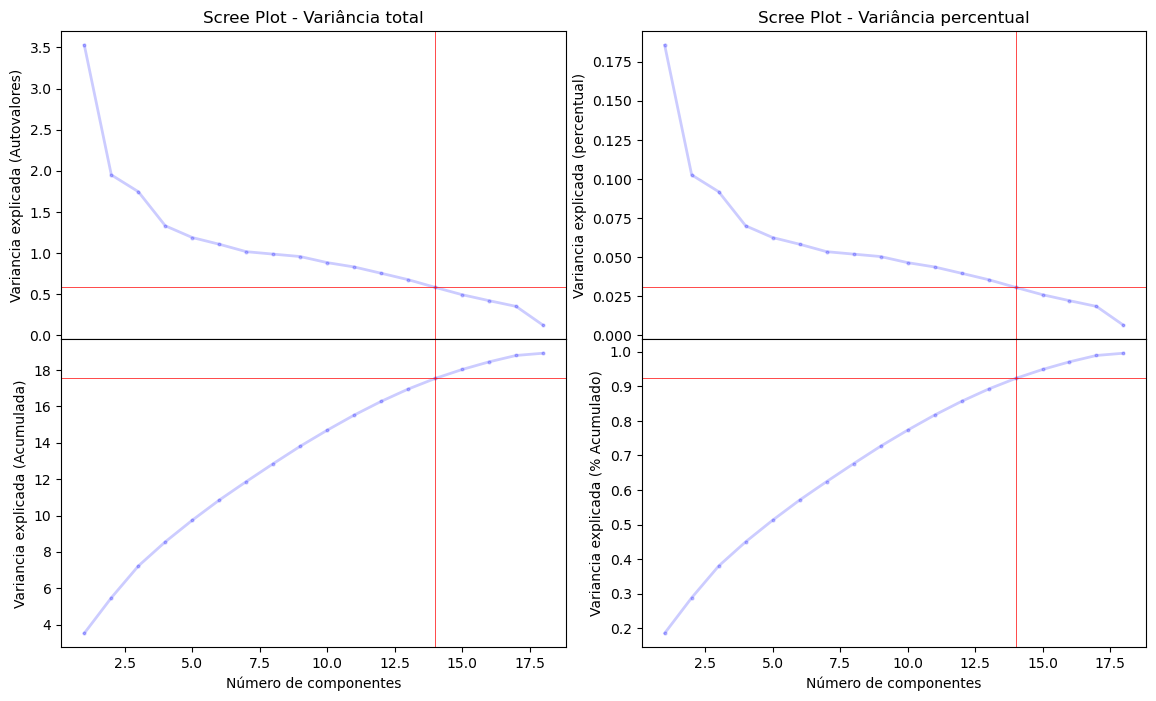

14

In [28]:
screeplot(
        prcomp, varexplicada=0.90
    )  # Chama a função screeplot para visualizar a variância explicada pelos componentes principais

In [29]:
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(18)])  # Cria um DataFrame com os componentes principais

In [30]:
silhuette_scores_pca = []  # Lista para armazenar os scores de silhueta de cada solução de agrupamento
max_clusters = 10      # Número máximo de clusters a ser testado
dict_grupos_pca = {}       # Dicionário para armazenar os rótulos dos grupos como categorias nomeadas

# Loop para testar diferentes quantidades de clusters (de 2 até max_clusters)
for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)  # Instancia o modelo KMeans
    kmeans.fit(df_pca)  # Ajusta o modelo aos dados transformados pelo PCA
    silhuette_scores_pca.append(silhouette_score(df_pca, kmeans.labels_))  # Calcula e armazena o índice de silhueta
    nomes_grupos = [f'Grupo_{i}' for i in range(n_clusters)]  # Cria nomes para os grupos (ex: Grupo_0, Grupo_1, ...)
    df_pca[f'Grupo_{n_clusters}'] = kmeans.labels_  # Adiciona ao DataFrame os rótulos dos grupos (como números)
    # Adiciona ao dicionário os rótulos dos grupos como categorias nomeadas (ex: 'Grupo_0', 'Grupo_1', ...)
    dict_grupos_pca[f'Grupo_{n_clusters}'] = pd.Categorical.from_codes(kmeans.labels_, categories=nomes_grupos)

# Cria uma cópia do DataFrame com os componentes principais
df_pca1 = df_pca.copy()
# Substitui as colunas de grupos numéricos por categorias nomeadas no novo DataFrame
df_pca1[['Grupo_' + str(x) for x in range(2, max_clusters + 1)]] = pd.DataFrame(dict_grupos_pca)

<Axes: xlabel='n_clusters'>

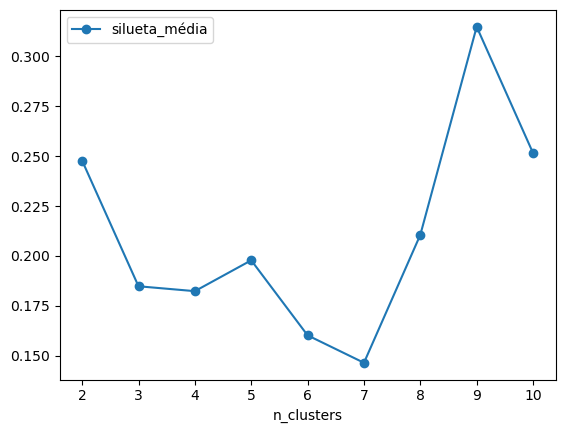

In [31]:
# Cria um DataFrame com o número de clusters testados e os respectivos valores médios do índice de silhueta
df_silueta_pca = pd.DataFrame({'n_clusters': list(range(2, max_clusters+1)), 'silueta_média': silhuette_scores_pca})

# Plota um gráfico de linha mostrando como o índice de silhueta médio varia conforme o número de clusters
df_silueta_pca.plot.line(x='n_clusters', y='silueta_média', marker='o')

<Axes: xlabel='n_clusters', ylabel='silueta_média'>

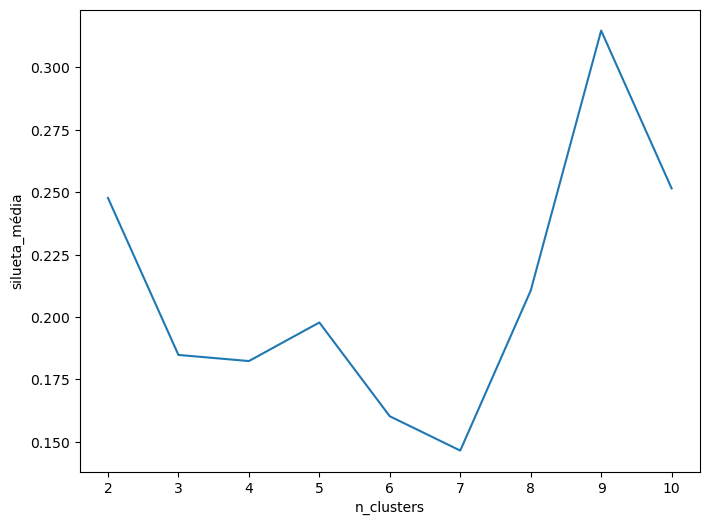

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(data=df_silueta_pca, x='n_clusters', y='silueta_média', markers='o')

In [33]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,Grupo_2,Grupo_3,Grupo_4,Grupo_5,Grupo_6,Grupo_7,Grupo_8,Grupo_9,Grupo_10
0,-3.424143,3.198253,0.940647,2.263482,-0.067481,-0.554300,-0.961334,-0.087856,-0.227686,-1.060538,-0.515269,0.015813,-1.343413,0.490698,0.095880,0.171943,-0.091418,0.095036,0,2,3,2,3,2,2,7,6
1,-1.620107,0.828470,-0.608352,-0.324682,0.505499,-0.264725,-0.262639,-0.619915,-0.701340,-0.642985,0.569300,0.277952,-0.969662,0.288986,0.126447,-0.146657,0.043206,-0.173071,0,2,2,2,5,4,4,3,1
2,-3.563232,1.730770,2.879502,1.331985,0.054255,-0.631704,-1.086206,0.037831,2.265093,-0.104068,0.318245,2.294977,-1.103120,-1.007622,0.114685,0.099014,-0.068379,0.094020,0,2,3,2,3,2,2,7,6
3,-2.237559,0.962413,0.718201,0.113590,0.520254,-0.293288,-0.330157,-0.245103,-0.484360,-0.470858,0.717028,0.908677,-1.026945,-0.306430,0.110310,-0.075423,0.017187,-0.124817,0,2,3,2,3,2,2,7,4
4,-1.178160,0.121976,-0.129936,-0.786004,0.598876,-0.498956,1.415775,1.001370,-0.316343,-1.300062,1.056577,0.291421,-1.000732,-0.241072,0.021607,-0.190557,0.033103,-0.100135,0,2,2,2,4,4,4,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.680196,-1.155003,0.933624,-0.488745,-0.347154,0.887079,1.201991,1.046399,-0.298272,-2.355292,1.044241,-0.037375,1.292796,-1.053698,-0.768396,-0.240937,-0.062851,0.081892,0,2,2,2,4,1,1,5,3
12326,-0.670242,-0.691019,-0.176121,-0.446282,-0.689719,0.348173,1.989009,1.314913,-0.778910,0.229640,0.896632,0.172699,0.540336,-0.079652,-0.143574,-0.301023,0.059696,-0.142774,0,2,2,2,4,1,1,5,3
12327,-1.697443,0.026145,1.316865,0.646768,-0.757629,0.245526,1.825890,1.990790,-0.939790,0.825421,0.777582,-0.186544,0.164707,-0.352751,-0.170727,-0.116559,0.002214,0.026777,0,2,2,2,4,1,1,5,3
12328,-0.143429,-0.508764,0.046524,-0.440089,-0.719809,0.514749,-0.314035,0.402771,-0.742461,1.684747,0.718718,-0.538907,0.393686,0.147933,-0.086315,0.249781,-0.350174,-0.056856,0,2,2,2,5,1,2,5,3


### Avaliando os agrupamentos

In [34]:
df_agrupamento = df1.copy()

for nome_coluna, valores in dict_grupos_pca.items():
    df_agrupamento[nome_coluna] = valores

In [35]:
df_agrupamento

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,VisitorType_Other,VisitorType_Returning_Visitor,Grupo_2,Grupo_3,Grupo_4,Grupo_5,Grupo_6,Grupo_7,Grupo_8,Grupo_9,Grupo_10
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,1,1,1,1,False,False,False,True,Grupo_0,Grupo_2,Grupo_3,Grupo_2,Grupo_3,Grupo_2,Grupo_2,Grupo_7,Grupo_6
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,2,1,2,False,False,False,True,Grupo_0,Grupo_2,Grupo_2,Grupo_2,Grupo_5,Grupo_4,Grupo_4,Grupo_3,Grupo_1
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,4,1,9,3,False,False,False,True,Grupo_0,Grupo_2,Grupo_3,Grupo_2,Grupo_3,Grupo_2,Grupo_2,Grupo_7,Grupo_6
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,2,3,2,2,4,False,False,False,True,Grupo_0,Grupo_2,Grupo_3,Grupo_2,Grupo_3,Grupo_2,Grupo_2,Grupo_7,Grupo_4
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,2,3,3,1,4,True,False,False,True,Grupo_0,Grupo_2,Grupo_2,Grupo_2,Grupo_4,Grupo_4,Grupo_4,Grupo_3,Grupo_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,12,4,6,1,1,True,False,False,True,Grupo_0,Grupo_2,Grupo_2,Grupo_2,Grupo_4,Grupo_1,Grupo_1,Grupo_5,Grupo_3
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,11,3,2,1,8,True,False,False,True,Grupo_0,Grupo_2,Grupo_2,Grupo_2,Grupo_4,Grupo_1,Grupo_1,Grupo_5,Grupo_3
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,11,3,2,1,13,True,False,False,True,Grupo_0,Grupo_2,Grupo_2,Grupo_2,Grupo_4,Grupo_1,Grupo_1,Grupo_5,Grupo_3
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,11,2,2,3,11,False,False,False,True,Grupo_0,Grupo_2,Grupo_2,Grupo_2,Grupo_5,Grupo_1,Grupo_2,Grupo_5,Grupo_3


In [ ]:
# Define opções de exibição do pandas para mostrar todas as colunas e não truncar o conteúdo das células
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

# Função para plotar a proporção de cada categoria de uma coluna do DataFrame
def plotar_proporcao(coluna: str, df=df_agrupamento):
    # Calcula a proporção (%) de cada grupo na coluna selecionada
    proporcao = df[coluna].value_counts(normalize=True) * 100
    # Plota um gráfico de barras das proporções
    proporcao.plot(kind="bar", color="skyblue")

    # Adiciona o valor percentual acima de cada barra do gráfico
    for i, valor in enumerate(proporcao):
        plt.text(i, valor + 0.5, f"{valor:.2f}%", ha="center", va="bottom", fontsize=10)

    plt.title(f"Proporção dos grupos em {coluna}")  # Define o título do gráfico
    plt.xlabel("Grupos")                            # Rótulo do eixo X
    plt.ylabel("Proporção (%)")                     # Rótulo do eixo Y
    plt.xticks(rotation=45)                         # Rotaciona os rótulos do eixo X para melhor visualização
    plt.show()                                      # Exibe o gráfico
    
    
def relacao_variaveis_x(grupo: int, coluna: str, df=df_agrupamento):
    # Plota gráfico de barras mostrando a média da variável 'coluna' por cluster e por Revenue
    ax = sns.barplot(
        data=df_agrupamento,
        x='Grupo_'+str(grupo),
        y=coluna,
        hue='Revenue',
        ci=None,
        palette='coolwarm',
    )

    # Adiciona os valores no topo de cada barra
    # Percorre todos os containers de barras do gráfico (um para cada grupo/hue)
    for container in ax.containers:
        # Para cada barra do container, adiciona o valor da média no topo da barra
        # fmt='%.2f' define que o valor será mostrado com duas casas decimais
        # label_type='edge' posiciona o texto na borda superior da barra
        # fontsize=10 define o tamanho da fonte dos rótulos
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)

    plt.title(f"Média de '{coluna}' por Cluster e Revenue")  # Título do gráfico
    plt.ylabel(f"Média de {coluna}")                         # Rótulo do eixo Y
    plt.xlabel(f"Cluster (Grupo_{grupo})")                   # Rótulo do eixo X
    plt.xticks(rotation=0)                                   # Mantém os rótulos do eixo X na horizontal
    plt.tight_layout()                                       # Ajusta o layout para não sobrepor elementos
    plt.show()                                               # Exibe o gráfico


#### Script Streamlit

In [37]:
# # Importa as bibliotecas necessárias para análise de dados e visualização
# import pandas as pd  # Manipulação de dados em DataFrames
# import matplotlib.pyplot as plt  # Criação de gráficos
# import seaborn as sns  # Visualização de dados estatísticos
# import numpy as np  # Operações numéricas e manipulação de arrays
# import streamlit as st

# from sklearn.decomposition import PCA  # Análise de Componentes Principais
# from sklearn.preprocessing import StandardScaler  # Normalização de dados
# from sklearn.cluster import KMeans  # Algoritmo de agrupamento K-Means
# from sklearn.metrics import silhouette_score  # Métrica de avaliação de agrupamentos


# def main():
#     # Configura o título da aplicação
#     st.set_page_config(
#         page_title="Projeto para criação de clusters",
#         layout="wide",
#         initial_sidebar_state="expanded",
#         page_icon="varig_icon.png",
#     )
#     st.markdown(
#         """
#     <link href="https://fonts.googleapis.com/css2?family=Kantumruy+Pro&display=swap" rel="stylesheet">

#     <h1 style='text-align: center; font-family: "Kantumruy Pro", sans-serif; font-size: 3em;'>
#         <strong>Clusterização do conjunto de dados</strong>
#     </h1>
#     """,
#         unsafe_allow_html=True,
#     )


# # Função para plotar o scree plot e determinar o número ideal de componentes principais
# @st.cache_data
# def calcular_info_screeplot(
#     explained_variance,
#     explained_variance_ratio,
#     n_components,
#     ncomp=0,
#     varexplicada=0,
#     criterio=1,
# ):
#     if ncomp > 0:
#         ncomp_crit = ncomp
#     elif varexplicada > 0:
#         ncomp_crit = (explained_variance_ratio.cumsum() < varexplicada).sum() + 1
#     elif criterio == 1:
#         ncomp_crit = (explained_variance_ratio > 1 / n_components).sum()
#     else:
#         ncomp_crit = None

#     variancia = explained_variance[ncomp_crit - 1]
#     variancia_acumulada = explained_variance.cumsum()[ncomp_crit - 1]
#     pct_variancia = explained_variance_ratio[ncomp_crit - 1]
#     pct_variancia_acumulada = explained_variance_ratio.cumsum()[ncomp_crit - 1]

#     return {
#         "ncomp_crit": ncomp_crit,
#         "variancia": variancia,
#         "variancia_acumulada": variancia_acumulada,
#         "pct_variancia": pct_variancia,
#         "pct_variancia_acumulada": pct_variancia_acumulada,
#     }


# def plotagem_de_graficos_silhueta(
#     explained_variance_, explained_variance_ratio_, n_components_, ncomp_crit
# ):
#     # Cria uma grade de subplots para os gráficos
#     fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
#     plt.subplots_adjust(hspace=0, wspace=0.15)

#     # Eixo X: número dos componentes principais
#     num_componentes = np.arange(n_components_) + 1

#     # Gráfico da variância explicada por componente
#     ax[0, 0].plot(
#         num_componentes,
#         explained_variance_,
#         "o-",
#         linewidth=2,
#         color="blue",
#         markersize=2,
#         alpha=0.2,
#     )
#     ax[0, 0].set_title("Scree Plot - Variância total")
#     ax[0, 0].set_xlabel("Número de componentes")
#     ax[0, 0].set_ylabel("Variancia explicada (Autovalores)")

#     # Gráfico da variância explicada acumulada
#     ax[1, 0].plot(
#         num_componentes,
#         explained_variance_.cumsum(),
#         "o-",
#         linewidth=2,
#         color="blue",
#         markersize=2,
#         alpha=0.2,
#     )
#     ax[1, 0].set_xlabel("Número de componentes")
#     ax[1, 0].set_ylabel("Variancia explicada (Acumulada)")

#     # Gráfico da variância percentual explicada por componente
#     ax[0, 1].plot(
#         num_componentes,
#         explained_variance_ratio_,
#         "o-",
#         linewidth=2,
#         color="blue",
#         markersize=2,
#         alpha=0.2,
#     )
#     ax[0, 1].set_title("Scree Plot - Variância percentual")
#     ax[0, 1].set_xlabel("Número de componentes")
#     ax[0, 1].set_ylabel("Variancia explicada (percentual)")

#     # Gráfico da variância percentual acumulada
#     ax[1, 1].plot(
#         num_componentes,
#         explained_variance_ratio_.cumsum(),
#         "o-",
#         linewidth=2,
#         color="blue",
#         markersize=2,
#         alpha=0.2,
#     )
#     ax[1, 1].set_xlabel("Número de componentes")
#     ax[1, 1].set_ylabel("Variancia explicada (% Acumulado)")

#     if ncomp_crit != None:
#         # Linhas verticais de referência para o número de componentes escolhido
#         ax[0, 0].axvline(x=ncomp_crit, color="r", linestyle="-", linewidth=0.5)
#         ax[1, 1].axvline(x=ncomp_crit, color="r", linestyle="-", linewidth=0.5)
#         ax[1, 0].axvline(x=ncomp_crit, color="r", linestyle="-", linewidth=0.5)
#         ax[0, 1].axvline(x=ncomp_crit, color="r", linestyle="-", linewidth=0.5)

#         # Linhas horizontais de referência para os valores correspondentes ao componente escolhido
#         variancia = explained_variance_[ncomp_crit - 1]
#         variancia_acumulada = explained_variance_.cumsum()[ncomp_crit - 1]
#         pct_variancia = explained_variance_ratio_[ncomp_crit - 1]
#         pct_variancia_acumulada = explained_variance_ratio_.cumsum()[ncomp_crit - 1]

#         ax[0, 0].axhline(y=variancia, color="r", linestyle="-", linewidth=0.5)
#         ax[1, 0].axhline(y=variancia_acumulada, color="r", linestyle="-", linewidth=0.5)
#         ax[0, 1].axhline(y=pct_variancia, color="r", linestyle="-", linewidth=0.5)
#         ax[1, 1].axhline(
#             y=pct_variancia_acumulada, color="r", linestyle="-", linewidth=0.5
#         )
#     plt.show()
#     st.pyplot(fig)


# @st.cache_data
# def calcular_ausentes_por_coluna(df):
#     ausentes_por_coluna = df.isna().sum()
#     return ausentes_por_coluna


# def transformacao_padrao(df):
#     """
#     Função para padronizar os dados de um DataFrame.
#     """
#     scaler = StandardScaler()
#     df_padrao = scaler.fit_transform(df)
#     return df_padrao


# def ajuste_modelo_pca(df1_padrao):
#     """
#     Função para ajustar o modelo PCA aos dados padronizados.
#     """
#     pca = PCA(n_components=18)
#     pca.fit(df1_padrao)
#     return pca


# def preprocessamento(df):
#     # Dicionário para mapear nomes dos meses (em inglês) para seus respectivos números
#     numeracao_meses = {
#         "Jan": 1,
#         "Feb": 2,
#         "Mar": 3,
#         "Apr": 4,
#         "May": 5,
#         "June": 6,
#         "Jul": 7,
#         "Aug": 8,
#         "Sep": 9,
#         "Oct": 10,
#         "Nov": 11,
#         "Dec": 12,
#     }
#     df["Month"] = df["Month"].map(numeracao_meses)
#     df = pd.get_dummies(df, columns=["VisitorType"], drop_first=True)
#     return df


# # Executa a função main para iniciar o aplicativo Streamlit
# main()

# # Cria a barra lateral do aplicativo Streamlit
# # Gera um campo de upload de arquivo na barra lateral para o usuário carregar um arquivo CSV
# uploaded_file = st.sidebar.file_uploader("Escolha um arquivo CSV", type="csv")

# # Define o caminho do arquivo da imagem que será exibida no aplicativo
# imagem_rotulo_app = "Varig_Logo.png"

# st.markdown("---")

# # Cria uma divisão de layout em três colunas, sendo a coluna do meio (col2) duas vezes maior que as laterais
# col1, col2, col3 = st.columns([1, 2, 1])

# # Exibe a imagem na coluna do meio (col2) com largura de 200 pixels e legenda personalizada
# col2.image(
#     imagem_rotulo_app, use_container_width=True, caption="Varig - Agrupamento de Dados"
# )

# col1, col2, col3 = st.columns([1, 3, 1])

# col2.markdown("## Tratamento, limpeza e conversão para PCA do conjunto de dados")

# # Verifica se um arquivo foi carregado pelo usuário na barra lateral
# if uploaded_file is not None:
#     # Lê o arquivo CSV carregado e armazena em um DataFrame do pandas
#     df = pd.read_csv(uploaded_file)

#     # Verifica a quantidade de valores ausentes em cada coluna do DataFrame

#     col1, col2, col3 = st.columns([1, 1, 1])

#     # Exibe a quantidade de valores ausentes por coluna no aplicativo Streamlit
#     if st.checkbox("Exibir valores ausentes por coluna"):
#         col1, col2, col3 = st.columns([1, 1, 1])
#         # Exibe a quantidade de valores ausentes por coluna no aplicativo Streamlit
#         col1.markdown(
#             """
#         <link href="https://fonts.googleapis.com/css2?family=Kantumruy+Pro&display=swap" rel="stylesheet">

#         <h1 style='text-align: center; font-family: "Kantumruy Pro", sans-serif; font-size: 1.2em; align-items: center;'>
#             <strong>Quantidade de valores ausentes por coluna</strong>
#         </h1>
#         """,
#             unsafe_allow_html=True,
#         )
#         col1.dataframe(calcular_ausentes_por_coluna(df))

#     # Cria uma cópia do DataFrame original para evitar alterações indesejadas no df original
#     df1 = df.copy()

#     # Converte a coluna 'Month' de nomes dos meses para números inteiros usando o dicionário de mapeamento
#     # e aplica o pré-processamento para transformar a coluna 'VisitorType' em variáveis dummy
#     # usando a função preprocessamento definida acima
#     df1 = df1.pipe(preprocessamento)

#     # Padroniza os dados do DataFrame usando a função transformacao_padrao
#     # que aplica a normalização z-score (média 0 e desvio padrão 1)
#     df1_padrao = transformacao_padrao(df1)

#     # Ajusta o modelo PCA para 18 componentes principais usando os dados padronizados
#     prcomp = ajuste_modelo_pca(df1_padrao)

#     # Aplica a transformação PCA aos dados normalizados, reduzindo a dimensionalidade
#     df_pca = prcomp.transform(df1_padrao)

#     # Exibe o scree plot e as informações sobre a variância explicada
#     if st.checkbox("Demonstrar dados da otimização PCA"):
#         info = calcular_info_screeplot(
#             prcomp.explained_variance_,
#             prcomp.explained_variance_ratio_,
#             prcomp.n_components_,
#             varexplicada=0.90,
#         )

#         st.markdown(f"Número de componentes:............... {info['ncomp_crit']}")
#         st.markdown(f"Variância da ultima CP:.............. {info['variancia']:.2f}")
#         st.markdown(
#             f"Variância total explicada:........... {info['variancia_acumulada']:.2f}"
#         )
#         st.markdown(
#             f"Variância percentual da última CP:... {100*info['pct_variancia']:.2f}%"
#         )
#         st.markdown(
#             f"Variância percentual total explicada: {100*info['pct_variancia_acumulada']:.2f}%"
#         )

#         st.session_state["calcular_info_screeplot"] = info

#     # Plota os gráficos de variância explicada e percentual explicada
#     if st.checkbox("Faça os gráficos para visualização"):
#         plotagem_de_graficos_silhueta(
#             prcomp.explained_variance_,
#             prcomp.explained_variance_ratio_,
#             prcomp.n_components_,
#             ncomp_crit=st.session_state["calcular_info_screeplot"]["ncomp_crit"],
#         )

#     # Checkbox para autorizar o inicio de um processo de testes com múltiplos modelos de agrupamentos
#     # Para ao final termos um conjunto de dados com variáveis que indicam os agrupamentos com diferentes números de grupos

#     st.markdown("---")
#     col1, col2, col3 = st.columns([1, 2, 1])
#     col2.markdown("## Análise de diferentes modelos de agrupamento")

#     if st.checkbox(
#         "Faça a avaliação de múltiplos modelos de agrupamento, para definir qual o melhor sucedido"
#     ):

#         df_pca = pd.DataFrame(
#             df_pca, columns=[f"PC{i+1}" for i in range(18)]
#         )  # Cria um DataFrame com os componentes principais

#         # Lista para armazenar os scores de silhueta de cada solução de agrupamento
#         silhuette_scores_pca = []

#         # Número máximo de clusters a ser testado
#         max_clusters = st.number_input(
#             "Defina o número máximo de clusters",
#             help="Decida a quantidade de clusters que serão testados. Quanto maior a quantidade, maior será o processamento",
#             min_value=2,
#             max_value=20,
#             step=1,
#             value=3,
#         )

#         # Dicionário para armazenar os rótulos dos grupos como categorias nomeadas
#         dict_grupos_pca = {}

#         # Loop para testar diferentes quantidades de clusters (de 2 até max_clusters)
#         for n_clusters in range(2, max_clusters + 1):
#             # Instancia o modelo KMeans
#             kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#             # Ajusta o modelo aos dados transformados pelo PCA
#             kmeans.fit(df_pca)
#             # Calcula e armazena o índice de silhueta
#             silhuette_scores_pca.append(silhouette_score(df_pca, kmeans.labels_))
#             # Cria nomes para os grupos (ex: Grupo_0, Grupo_1, ...)
#             nomes_grupos = [f"Grupo_{i}" for i in range(n_clusters)]
#             # Adiciona ao DataFrame os rótulos dos grupos (como números)
#             df_pca[f"Grupo_{n_clusters}"] = kmeans.labels_
#             # Adiciona ao dicionário os rótulos dos grupos como categorias nomeadas (ex: 'Grupo_0', 'Grupo_1', ...)
#             dict_grupos_pca[f"Grupo_{n_clusters}"] = pd.Categorical.from_codes(
#                 kmeans.labels_, categories=nomes_grupos
#             )

#         # loop for para atribuir nomes editados a cada um dos clusters nas colunas
#         # nome_coluna carrega as keys do dicionário
#         # valores carrega as listas atribuidas a cada chave
#         for nome_coluna, valores in dict_grupos_pca.items():
#             df_pca[nome_coluna] = valores

#         colunas_grupos = [col for col in df_pca.columns if col.startswith("Grupo_")]

#         st.dataframe(df_pca[colunas_grupos])

In [38]:
# # Importa as bibliotecas necessárias para análise de dados e visualização
# import pandas as pd  # Manipulação de dados em DataFrames
# import matplotlib.pyplot as plt  # Criação de gráficos
# import seaborn as sns  # Visualização de dados estatísticos
# import numpy as np  # Operações numéricas e manipulação de arrays
# import streamlit as st

# from sklearn.decomposition import PCA  # Análise de Componentes Principais
# from sklearn.preprocessing import StandardScaler  # Normalização de dados
# from sklearn.cluster import KMeans  # Algoritmo de agrupamento K-Means
# from sklearn.metrics import silhouette_score  # Métrica de avaliação de agrupamentos


# def main():
#     # Configura o título da aplicação
#     st.set_page_config(
#         page_title="Projeto para criação de clusters",
#         layout="wide",
#         initial_sidebar_state="expanded",
#         page_icon="varig_icon.png",
#     )
#     st.markdown(
#         """
#     <link href="https://fonts.googleapis.com/css2?family=Kantumruy+Pro&display=swap" rel="stylesheet">

#     <h1 style='text-align: center; font-family: "Kantumruy Pro", sans-serif; font-size: 3em;'>
#         <strong>Clusterização do conjunto de dados</strong>
#     </h1>
#     """,
#         unsafe_allow_html=True,
#     )


# main()

# uploaded_file = st.sidebar.file_uploader("Escolha um arquivo CSV", type="csv")

# # Define o caminho do arquivo da imagem que será exibida no aplicativo
# imagem_rotulo_app = "Varig_Logo.png"

# st.markdown("---")

# # Cria uma divisão de layout em três colunas, sendo a coluna do meio (col2) duas vezes maior que as laterais
# col1, col2, col3 = st.columns([1, 2, 1])

# # Exibe a imagem na coluna do meio (col2) com largura de 200 pixels e legenda personalizada
# col2.image(
#     imagem_rotulo_app, use_container_width=True, caption="Varig - Agrupamento de Dados"
# )

# # Verifica se um arquivo foi carregado pelo usuário na barra lateral
# if uploaded_file is not None:
#     # Lê o arquivo CSV carregado e armazena em um DataFrame do pandas
#     df = pd.read_csv(uploaded_file)

#     # Verifica a quantidade de valores ausentes em cada coluna do DataFrame
#     ausentes_por_coluna = df.isna().sum()
#     col1, col2, col3 = st.columns([1, 1, 1])

#     # Exibe a quantidade de valores ausentes por coluna no aplicativo Streamlit
#     col1.write("Valores ausentes por coluna:")
#     col1.write(ausentes_por_coluna)